In [1]:
import logging
import numpy as np
import perceval as pcvl
from perceval.algorithm import Sampler
from perceval.components import PS, BS
import sys

from utils import svd_decomposition, print_circuit_structure
from clements import decompose_clements

logging.basicConfig(
    stream=sys.stdout,      # Direct logs to stdout
    level=logging.DEBUG
)

### Input Matrix

In [2]:
# H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])

# # Calculate the 2-qubit Hadamard matrix using the Kronecker product
# A = np.kron(H, H).astype(np.complex128)
# A

A = np.array([
    [ 1.0,  0.0,  0.0,  0.0],
    [ 0.0,  1.0,  0.0,  0.0],
    [ 0.0,  0.0,  0.0,  1.0],
    [ 0.0,  0.0,  1.0,  0.0]
]).astype(np.complex128)

### SVD Decomposition

In [3]:
U, S, Vt = svd_decomposition(A)

DEBUG:root:--- 1. Original Matrix A ---
DEBUG:root:[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]
DEBUG:root:Input Matrix Shape: (4, 4)
DEBUG:root:--- 2. Decomposition Components ---
DEBUG:root:Matrix U (Left Singular Vectors):
DEBUG:root:[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]]
DEBUG:root:Shape: (4, 4)

DEBUG:root:Vector S (Singular Values):
DEBUG:root:[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
DEBUG:root:Shape: (4, 4)

DEBUG:root:Matrix Vt (Right Singular Vectors Transposed):
DEBUG:root:[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j -1.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]]
DEBUG:root:Shape: (4, 4)



### Running Clement's Decomposition

#### Running for Vt

In [4]:
V_c = decompose_clements(Vt)

In [5]:
print_circuit_structure(*V_c)
print(V_c)

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=1.571, theta=1.571

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=6.283, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = 1.571
  WG-1: Phase Shifter = -3.142
  WG-2: Phase Shifter = -3.142
  WG-3: Phase Shifter = -0.000
(array([[3.14159265, 4.71238898],
       [3.14159265, 6.28318531],
       [1.57079633, 4.71238898]]), array([[1.57079633, 1.57079633],
       [1.57079633, 1.57079633],
       [1.57079633, 1.57079633]]), array([ 1.57079633e+00, -3.14159265e+00, -3.14159265e+00, -2.29584502e-49]))


#### Running For Sigma

In [6]:
S_c = decompose_clements(S)
print_circuit_structure(*S_c)
print(S_c)

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=1.571

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=3.142, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = 1.571
  WG-1: Phase Shifter = 0.000
  WG-2: Phase Shifter = 0.000
  WG-3: Phase Shifter = -3.142
(array([[3.14159265, 4.71238898],
       [3.14159265, 3.14159265],
       [4.71238898, 1.57079633]]), array([[1.57079633, 1.57079633],
       [1.57079633, 1.57079633],
       [1.57079633, 1.57079633]]), array([ 1.57079633e+00,  2.44929360e-16,  2.28847549e-17, -3.14159265e+00]))


#### Running for U

In [7]:
U_c = decompose_clements(U)
print_circuit_structure(*U_c)
print(U_c)

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=0.000

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=3.142, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = -3.142
  WG-1: Phase Shifter = 1.571
  WG-2: Phase Shifter = 1.571
  WG-3: Phase Shifter = -1.571
(array([[3.14159265, 3.14159265],
       [1.57079633, 3.14159265],
       [4.71238898, 1.57079633]]), array([[1.57079633, 1.57079633],
       [1.57079633, 1.57079633],
       [0.        , 1.57079633]]), array([-3.14159265,  1.57079633,  1.57079633, -1.57079633]))


### Simulation with Perceval

In [8]:
[v_phis, v_thetas, v_alphas] = V_c
vt_circuit = (
    pcvl.Circuit(4, name="Vt")
    ## MZI 1
    .add(0,PS(phi=v_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * v_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=v_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * v_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=v_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * v_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=v_alphas[0]))
    # .add(1, PS(phi=v_alphas[1]))
    # .add(2, PS(phi=v_alphas[2]))
    # .add(3, PS(phi=v_alphas[3]))
)

In [9]:
[s_phis, s_thetas, s_alphas] = S_c
s_circuit = (
    pcvl.Circuit(4, name="S")
    ## MZI 1
    .add(0,PS(phi=s_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * s_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=s_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * s_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=s_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * s_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=s_alphas[0]))
    # .add(1, PS(phi=s_alphas[1]))
    # .add(2, PS(phi=s_alphas[2]))
    # .add(3, PS(phi=s_alphas[3]))
)

In [10]:
[u_phis, u_thetas, u_alphas] = U_c
u_circuit = (
    pcvl.Circuit(4, name="U")
    ## MZI 1
    .add(0,PS(phi=u_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * u_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=u_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * u_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=u_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * u_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=u_alphas[0]))
    # .add(1, PS(phi=u_alphas[1]))
    # .add(2, PS(phi=u_alphas[2]))
    # .add(3, PS(phi=u_alphas[3]))
)

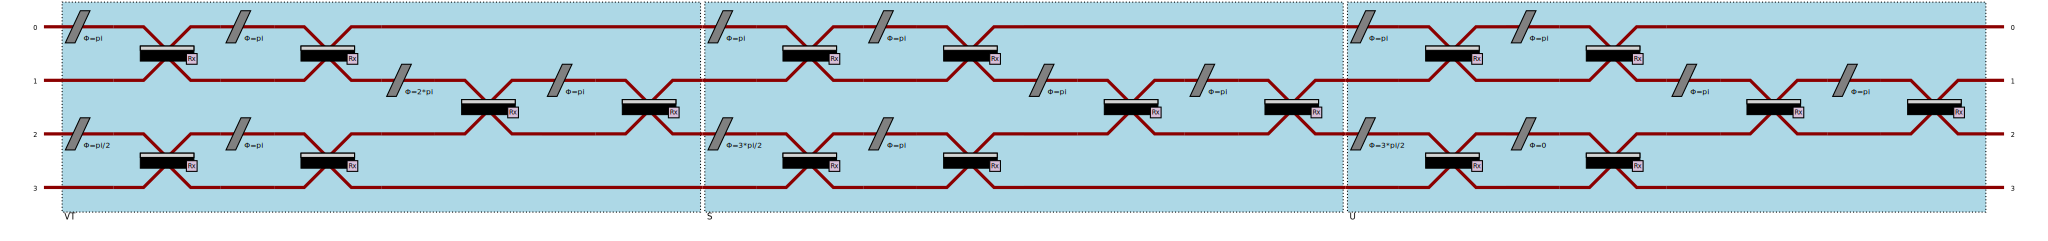

In [11]:
circuit = (pcvl.Circuit(4)
      .add(0, vt_circuit, merge=False)
      .add(0, s_circuit, merge=False)
      .add(0, u_circuit, merge=False)
)

pcvl.pdisplay(circuit, recursive=True)

In [12]:
circuit.compute_unitary()

MatrixN([[ 1.00000000e+00-5.51091060e-16j,
           6.12323400e-17-4.87421929e-32j,
           3.74939946e-33-7.49879891e-33j,
          -6.88753506e-49-2.29584502e-49j],
         [ 6.12323400e-17-2.24963967e-32j,
          -1.00000000e+00+8.57252759e-16j,
          -6.12323400e-17+6.12323400e-17j,
           2.73691106e-48-6.12323400e-17j],
         [ 3.74939946e-33-6.88753506e-49j,
          -6.12323400e-17+5.10903053e-32j,
           6.12323400e-17-1.60812265e-16j,
           1.83697020e-16+1.00000000e+00j],
         [-1.23233305e-48-3.74939946e-33j,
          -6.12323400e-17-6.12323400e-17j,
           1.00000000e+00-6.73555740e-16j,
           1.60812265e-16-6.12323400e-17j]])

In [13]:
p = pcvl.Processor("SLOS", circuit)
p.min_detected_photons_filter(1)
p.compute_physical_logical_perf(True)

p.with_input(pcvl.BasicState([0,1,1,0]))
sampler = Sampler(p)
probs = sampler.probs()
print(probs['results'])

{
	|0,1,0,1>: 1
}
